# Insurance Fraud Claims Detection

In this notebook, I'm going to train the model with engineered data and selected features.

## Libraries and Enviroments

In [1]:
#Read the data
import numpy as np 
import pandas as pd

# Data Sciences
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline

#Utils
import os

# Set notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.simplefilter(action='ignore')

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
raw = '../data/raw/insurance_claims.csv'
interim = '../data/interim/'
processed= '../data/processed/'
models= '../models/'

## Data Preparation

### Read Data

In [3]:
data = pd.read_csv(processed + 'data_final.csv')
features = [col for col in data.columns if col != 'fraud_reported']

### Train-Test splitting

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data['fraud_reported'], 
                                                    test_size=0.20, 
                                                    random_state=1) # ALWAYS set random seed for reproducibility!
X_train.shape, X_test.shape

((799, 55), (200, 55))

In [5]:
print(X_train.shape)
print(X_test.shape)

(799, 55)
(200, 55)


### Feature Scaling

In [6]:
# create scaler
scaler = MinMaxScaler()

#  fit the scaler to the train set
scaler.fit(X_train) 

# transform the train and test set
X_train[features] = scaler.transform(X_train)
X_test[features] = scaler.transform(X_test)

### Load features

In [7]:
features_selected = pd.read_csv(processed + 'selected_features.csv', header=None, names=['features'])
features_selected = list(features_selected['features'])

print('Number of features: ', len(features))
print('\n', sorted(features))

Number of features:  55

 ['age_groups_15-20', 'age_groups_21-25', 'age_groups_26-30', 'age_groups_31-35', 'age_groups_36-40', 'age_groups_41-45', 'age_groups_46-50', 'age_groups_51-55', 'age_groups_56-60', 'age_groups_61-65', 'authorities_contacted_Ambulance', 'authorities_contacted_Fire', 'authorities_contacted_None', 'authorities_contacted_Other', 'authorities_contacted_Police', 'bodily_injuries', 'capital_gains', 'capital_loss', 'collision_type_Front Collision', 'collision_type_Rear Collision', 'collision_type_Side Collision', 'collision_type_missing', 'incident_hour_of_the_day', 'incident_severity', 'incident_type_Multi-vehicle Collision', 'incident_type_Parked Car', 'incident_type_Single Vehicle Collision', 'incident_type_Vehicle Theft', 'insured_hobbies_chess', 'insured_hobbies_cross-fit', 'insured_hobbies_others', 'insured_sex_FEMALE', 'insured_sex_MALE', 'months_as_customer_groups_0-50', 'months_as_customer_groups_101-150', 'months_as_customer_groups_151-200', 'months_as_custo

In [8]:
X_train = X_train[features_selected]
X_test = X_test[features_selected]

### Smote for balancing

#### Target distribution

In [9]:
print(y_train.value_counts()/len(y_train), '\n')

0    0.744681
1    0.255319
Name: fraud_reported, dtype: float64 



#### Smote for balancing

In [10]:
smote = SMOTE(random_state=9)
X_train, y_train = smote.fit_resample(X_train, y_train)

#### Syntetic Target distribution

In [11]:
print(y_train.value_counts()/len(y_train), '\n')

1    0.5
0    0.5
Name: fraud_reported, dtype: float64 



## Model Building

In [12]:
model_predictions = {}

### Logistic regression


********************
**Model Assessment**
********************
score: 0.63

Classification report
              precision    recall  f1-score   support

           0       0.85      0.64      0.73       157
           1       0.31      0.58      0.40        43

    accuracy                           0.63       200
   macro avg       0.58      0.61      0.57       200
weighted avg       0.73      0.63      0.66       200


Confusion Matrix


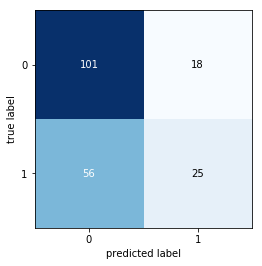

In [13]:
logit = LogisticRegression(random_state=8)

logit.fit(X_train, y_train)
predictions = logit.predict(X_test)

print()
print("*"*20)
print("Model Assessment".center(20, '*'))
print("*"*20)

predictions = logit.predict(X_test)
print('score: {}'.format(round(logit.score(X_test, y_test), 3)))
print()

print('Classification report')
print(classification_report(y_test, predictions))

print()

print('Confusion Matrix')
conf_matrix = confusion_matrix(predictions, y_test)
plot_confusion_matrix(conf_matrix);

tpr, fpr, threshold = roc_curve(predictions, y_test, pos_label=1)
model_predictions["Logistic Regression"] = [tpr, fpr]

### Support Vector Machine

********************
**Model Assessment**
********************
score: 0.78

Classification report
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       157
           1       0.49      0.72      0.58        43

    accuracy                           0.78       200
   macro avg       0.70      0.76      0.72       200
weighted avg       0.82      0.78      0.79       200


Confusion Matrix


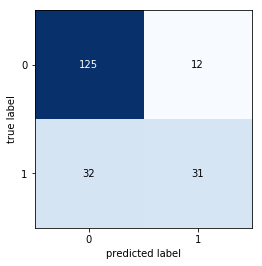

In [14]:
svc = SVC(random_state=8)

svc.fit(X_train, y_train)
predictions = svc.predict(X_test)

print("*"*20)
print("Model Assessment".center(20, '*'))
print("*"*20)

predictions = svc.predict(X_test)
print('score: {}'.format(round(svc.score(X_test, y_test), 3)))
print()

print('Classification report')
print(classification_report(y_test, predictions))

print()

print('Confusion Matrix')
conf_matrix = confusion_matrix(predictions, y_test)
plot_confusion_matrix(conf_matrix);

tpr, fpr, threshold = roc_curve(predictions, y_test, pos_label=1)
model_predictions["SVM"] = [tpr, fpr]

### Decision Tree

********************
**Model Assessment**
********************
score: 0.845

Classification report
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       157
           1       0.61      0.77      0.68        43

    accuracy                           0.84       200
   macro avg       0.77      0.82      0.79       200
weighted avg       0.86      0.84      0.85       200


Confusion Matrix


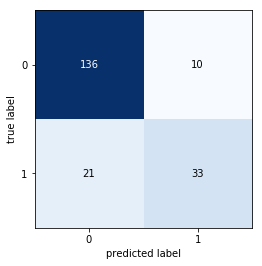

In [15]:
dtree = DecisionTreeClassifier(random_state=8)

dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

print("*"*20)
print("Model Assessment".center(20, '*'))
print("*"*20)

predictions = dtree.predict(X_test)
print('score: {}'.format(round(dtree.score(X_test, y_test), 3)))
print()

print('Classification report')
print(classification_report(y_test, predictions))

print()

print('Confusion Matrix')
conf_matrix = confusion_matrix(predictions, y_test)
plot_confusion_matrix(conf_matrix);

tpr, fpr, threshold = roc_curve(predictions, y_test, pos_label=1)
model_predictions["Decision Tree"] = [tpr, fpr]

### Random Forest

********************
**Model Assessment**
********************
score: 0.87

Classification report
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       157
           1       0.65      0.84      0.73        43

    accuracy                           0.87       200
   macro avg       0.80      0.86      0.82       200
weighted avg       0.89      0.87      0.88       200


Confusion Matrix


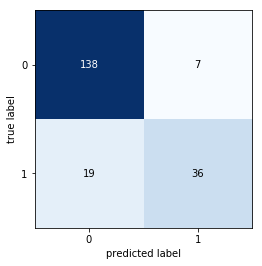

In [16]:
rfor = RandomForestClassifier(random_state=8)

rfor.fit(X_train, y_train)
predictions = rfor.predict(X_test)

print("*"*20)
print("Model Assessment".center(20, '*'))
print("*"*20)

print('score: {}'.format(round(rfor.score(X_test, y_test), 3)))
print()

print('Classification report')
print(classification_report(y_test, predictions))

print()

print('Confusion Matrix')
conf_matrix = confusion_matrix(predictions, y_test)
plot_confusion_matrix(conf_matrix);

tpr, fpr, threshold = roc_curve(predictions, y_test, pos_label=1)
model_predictions["Random Forest"] = [tpr, fpr]

### LightGB

********************
**Model Assessment**
********************
score: 0.86

Classification report
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       157
           1       0.63      0.84      0.72        43

    accuracy                           0.86       200
   macro avg       0.79      0.85      0.81       200
weighted avg       0.88      0.86      0.87       200


Confusion Matrix


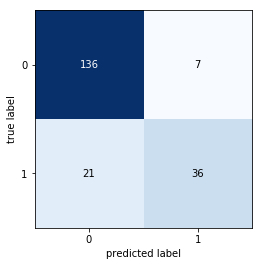

In [17]:
lgbm = LGBMClassifier(random_state=8)

lgbm.fit(X_train, y_train)
predictions = lgbm.predict(X_test)

print("*"*20)
print("Model Assessment".center(20, '*'))
print("*"*20)

predictions = lgbm.predict(X_test)
print('score: {}'.format(round(lgbm.score(X_test, y_test), 3)))
print()

print('Classification report')
print(classification_report(y_test, predictions))

print()

print('Confusion Matrix')
conf_matrix = confusion_matrix(predictions, y_test)
plot_confusion_matrix(conf_matrix);

tpr, fpr, threshold = roc_curve(predictions, y_test, pos_label=1)
model_predictions["LightGBM"] = [tpr, fpr]

## Model Assessment

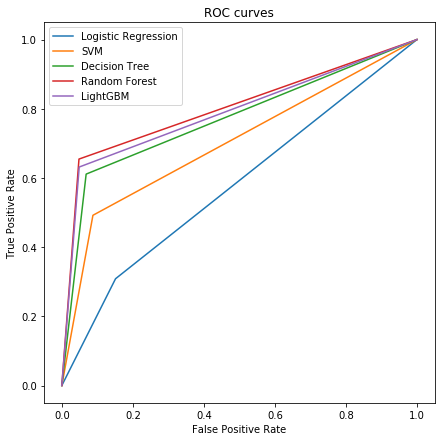

In [18]:
plt.figure(figsize=(7,7))
plt.title("ROC curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

for key, value in model_predictions.items():
    model_list = model_predictions[key]
    plt.plot(model_list[0], model_list[1], label=key)
    plt.legend()
plt.show()

## Model Tuning

In [ ]:
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyper = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

grid = GridSearchCV(rfor, hyper, cv = 3, verbose = 1, n_jobs = -1)
best = grid.fit(X_train, y_train)

In [ ]:
best.best_estimator_

********************
**Model Assessment**
********************
score: 0.88

Classification report
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       157
           1       0.67      0.88      0.76        43

    accuracy                           0.88       200
   macro avg       0.82      0.88      0.84       200
weighted avg       0.90      0.88      0.89       200


Confusion Matrix


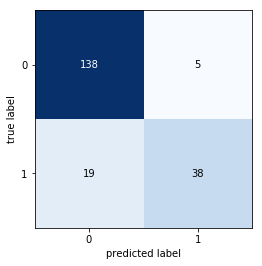

In [19]:
rfor_tune = RandomForestClassifier(max_depth=25, min_samples_split=5, n_estimators=300,
                       random_state=8)

rfor_tune.fit(X_train, y_train)
predictions = rfor_tune.predict(X_test)

print("*"*20)
print("Model Assessment".center(20, '*'))
print("*"*20)

predictions = rfor_tune.predict(X_test)
print('score: {}'.format(round(rfor_tune.score(X_test, y_test), 2)))
print()

print('Classification report')
print(classification_report(y_test, predictions))

print()

print('Confusion Matrix')
conf_matrix = confusion_matrix(predictions, y_test)
plot_confusion_matrix(conf_matrix);

tpr, fpr, threshold = roc_curve(predictions, y_test, pos_label=1)
model_predictions["Random Forest Tuned"] = [tpr, fpr]

## Conclusion

The best model is the **Random Forest** with a score of **0.88**